# Predicting Titanic passengers chances of survival

##### Etienne Viana and Sacha Roberse

In [306]:
# Data management
import numpy as np
import pandas as pd
import os

# Data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Utilities
import re

In [307]:
# Importing our datasets
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
data = [train_df, test_df]

## First Data Exploration:

In [308]:
# First look at available features
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [309]:
# Overview of numeric features
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [310]:
# Exploring correlations between all numeric features with scatter matrix -> not relevant
# pd.plotting.scatter_matrix(train_df, figsize=(20,20))
# plt.show()

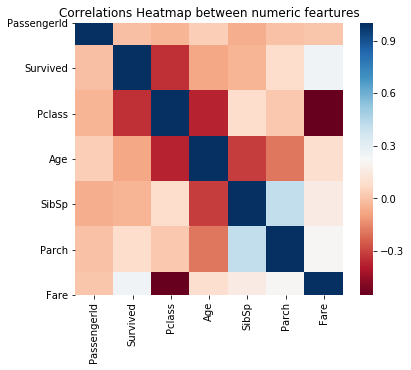

In [311]:
# Exploring correlations between all numeric features with heatmap
corr = train_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdBu")
plt.title('Correlations Heatmap between numeric feartures')
plt.show()

In [312]:
# Heatmap analysis
# We can see that :
#    there is an inverse correlation between passenger class and survival chance (More red)
#    there is a direct correlation between ticket fare and survival chance (More blue)

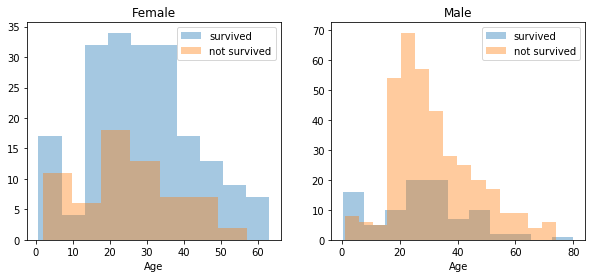

In [313]:
# Studying survival chance related to passenger's sex and age
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

# Plotting women chance of survival in relation to their age
sns.distplot(women[women['Survived']==1].Age.dropna() , label = 'survived', ax = axes[0], kde =False)
sns.distplot(women[women['Survived']==0].Age.dropna() , label = 'not survived', ax = axes[0], kde =False)
axes[0].legend()
axes[0].set_title('Female')

# Plotting men chance of survival in relation to their age
sns.distplot(men[men['Survived']==1].Age.dropna() , label = 'survived', ax = axes[1], kde = False)
sns.distplot(men[men['Survived']==0].Age.dropna() , label = 'not survived', ax = axes[1], kde = False)
axes[1].legend()
axes[1].set_title('Male')

plt.show()

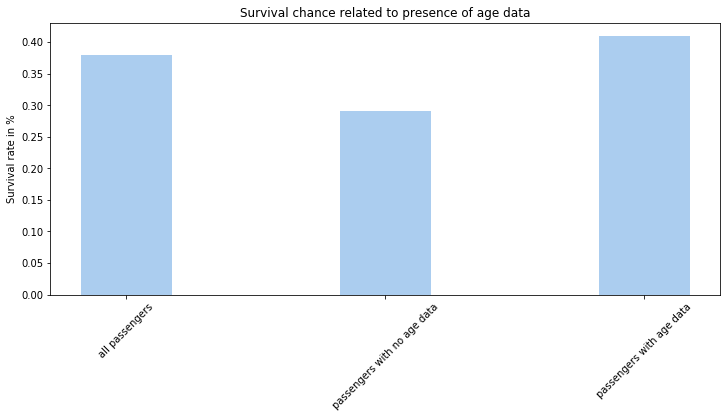

In [314]:
# Studying survival chance related to presence of age data
index = np.arange(3)
plt.figure(figsize=(12,5))
plt.bar(index,[round(train_df['Survived'].mean(), 2),
          round(train_df[train_df['Age'].isnull()]['Survived'].mean(), 2),
          round(train_df[train_df['Age'].notnull()]['Survived'].mean(), 2)], 0.35, color='#abcdef')

plt.ylabel('Survival rate in %')
plt.xticks(index, ('all passengers', 'passengers with no age data', 'passengers with age data'), rotation=45)
plt.title('Survival chance related to presence of age data')
plt.show()

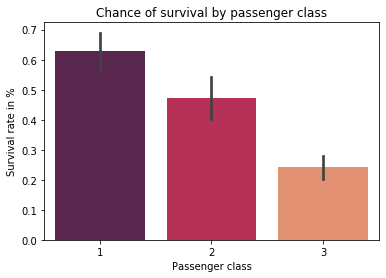

In [315]:
# Studying survival chance related to passenger class
sns.barplot(x='Pclass', y='Survived', palette='rocket', data=train_df)
plt.ylabel('Survival rate in %')
plt.xlabel('Passenger class')
plt.title('Chance of survival by passenger class')
plt.show()

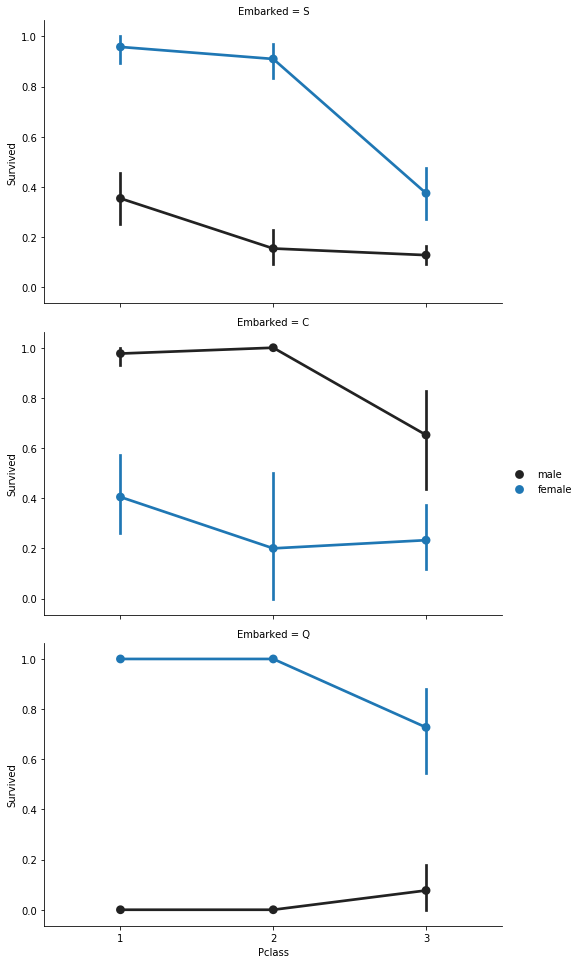

In [316]:
# Studying survival rate related to passenger class and embarked harbour
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()
plt.show()

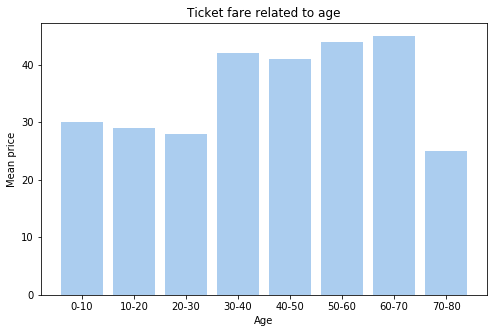

In [317]:
# Studying ticket fare related to age
bins = [0,10,20,30,40,50,60,70,80]
bins2 = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']

groups = train_df.groupby(pd.cut(train_df.Age, bins))

plt.figure(figsize=(8,5))
plt.bar(bins2, np.array(groups.mean()['Fare'].astype(int)), color='#abcdef')
plt.title('Ticket fare related to age')
plt.xlabel('Age')
plt.ylabel('Mean price')
plt.show()

## Data Preprocessing

In [318]:
# Sex data preprocessing
# Replacing male and female references by numeric values
Sex = {'male': 0, 'female': 1}
for dataset in data:
    dataset.Sex = dataset.Sex.map(Sex)

In [319]:
# Cabin data preprocessing
# Adding Decks referenced by Cabin letters and filling NaN Cabin data

# Ordering decks by chance increasing of survival
deck = {"A": 2, "B": 6, "C": 4, "D": 8, "E": 7, "F": 5, "G": 3, "U": 1} 
tofind = re.compile("([a-zA-Z]+)")
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: tofind.search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(1)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,S,1


In [320]:
# Looking at survival rate related to Deck
print(train_df.groupby('Deck').mean()['Survived'])

# for decknb in range(1,9): 
#     print("deck{} survival rate : {}".format(decknb,train_df[train_df['Deck'] == decknb]['Survived'].mean()))

Deck
1    0.299419
2    0.466667
3    0.500000
4    0.593220
5    0.615385
6    0.744681
7    0.750000
8    0.757576
Name: Survived, dtype: float64


In [321]:
# Port embarked preprocessing
# Removing NaN values (count : 2)
ports = {"S": 1, "Q": 2, "C": 3}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map(ports)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,1,1


In [322]:
# Looking at survival rate related to port embarked
print(train_df.groupby('Embarked').mean()['Survived'])

Embarked
1    0.339009
2    0.389610
3    0.553571
Name: Survived, dtype: float64


In [323]:
# Preprocessing titles
# Ordering them by rate of survival
titles = {'Mr': 1, 'Rare': 2, 'Master': 3, 'Miss': 4, 'Mrs': 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

In [324]:
print("Unique titles:\n{}".format(train_df['Title'].unique()))
print("\nNumber of passengers by title:\n{}".format(train_df['Title'].value_counts()))
print("\nRate of Survival by title:\n{}".format(train_df.groupby(['Title'])['Survived'].mean()))

Unique titles:
[1 5 4 3 2]

Number of passengers by title:
1    517
4    185
5    126
3     40
2     23
Name: Title, dtype: int64

Rate of Survival by title:
Title
1    0.156673
2    0.347826
3    0.575000
4    0.702703
5    0.793651
Name: Survived, dtype: float64


In [325]:
# Analysis : age by title
reverse_title = {1:'Mr', 2:'Rare', 3:'Master', 4:'Miss', 5:'Mrs'}
for title in range(1,6):
    print('{} :'.format(reverse_title[title]))
    print('  train set : {}'.format(round(train_df[(train_df['Title'] == title) & (train_df['Age'].notnull())]['Age'].mean())))
    print('  test set : {}\n'.format(round(test_df[(test_df['Title'] == title) & (test_df['Age'].notnull())]['Age'].mean())))

Mr :
  train set : 32.0
  test set : 32.0

Rare :
  train set : 46.0
  test set : 44.0

Master :
  train set : 5.0
  test set : 7.0

Miss :
  train set : 22.0
  test set : 22.0

Mrs :
  train set : 36.0
  test set : 39.0



In [326]:
# Adding Known_age feature as passenger with age data are more likely to survive
known_age = {False: 0, True: 1}

for dataset in data:
    dataset['Known_age'] = dataset['Age'].notnull()
    dataset['Known_age'] = dataset['Known_age'].map(known_age)

In [327]:
# Adding FamilySize and IsAlone features
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,1,1,1,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3,4,5,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,1,1,4,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,4,5,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,1,1,1,1,1,1


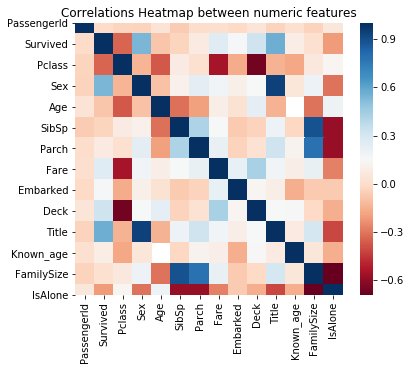

In [328]:
# New exploration of correlations after feature engineering
corr = train_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdBu")
plt.title('Correlations Heatmap between numeric features')
plt.show()

In [329]:
# Analysis of the heatmap
# The new heatmap reveal the strong relationships between survival and : class, sex, title, lonelyness

In [330]:
# Replace missing age data by age mean for each title

for dataset in data:
    title_means = {}
    for title in range(1,6):
        title_means.update({title:round(dataset.loc[(dataset['Title'] == title) & (dataset['Age'].notnull())]['Age'].mean())})
    for title in range(1,6):
        dataset.loc[(dataset['Title'] == title) & (dataset['Age'].isnull()), 'Age'] = title_means[title]

In [331]:
# Replace missing fare data for PassengerId 1044 (index 152) in test data
test_df.loc[152 ,'Fare'] = test_df['Fare'].mean()

In [332]:
# Keeping passenger IDs for submission
PassengerIds = test_df['PassengerId']

In [333]:
# Removing features that we will not use in our models
for dataset in data:
    dataset.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,0,3,0,22,1,0,7,1,1,1,1,2,0
1,1,1,1,38,1,0,71,3,4,5,1,2,0
2,1,3,1,26,0,0,7,1,1,4,1,1,1
3,1,1,1,35,1,0,53,1,4,5,1,2,0
4,0,3,0,35,0,0,8,1,1,1,1,1,1


In [334]:
# Setting bins for passenger age

for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

train_df['Age'].value_counts()

4    245
6    149
2    128
5    120
3    106
0     72
1     71
Name: Age, dtype: int64

In [335]:
# Setting bins for ticket fare

pd.qcut(train_df['Fare'], 5)
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7) & (dataset['Fare'] <= 10), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 21), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 21) & (dataset['Fare'] <= 39), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 39) & (dataset['Fare'] <= 512), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 512, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [336]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,0,3,0,2,1,0,0,1,1,1,1,2,0
1,1,1,1,5,1,0,4,3,4,5,1,2,0
2,1,3,1,3,0,0,0,1,1,4,1,1,1
3,1,1,1,5,1,0,4,1,4,5,1,2,0
4,0,3,0,5,0,0,1,1,1,1,1,1,1


## Initiating Train / Test sub datasets

In [337]:
from sklearn.model_selection import train_test_split

In [338]:
Y = pd.DataFrame.copy(train_df['Survived'])
X = train_df.drop(['Survived'], axis=1)

In [339]:
# Splitting our train and test sets
# Stratify is used to have the same proportion in survival in both sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify = Y)

## Training models

In [340]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [341]:
# Setting up different models
rf_clf = RandomForestClassifier()
lg_clf = LogisticRegression()
sv_clf = SVC()
kn_clf = KNeighborsClassifier(4)
ln_clf = LinearRegression()

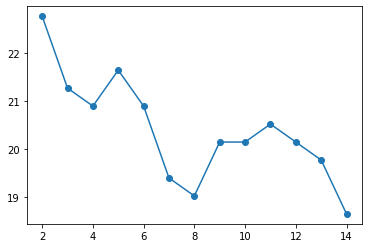

In [342]:
# Studying errors is KNN model depending of hyperparameter
errors = []
for k in range(2,15):
    knn = KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
    
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [343]:
# Fitting our models
rf_clf.fit(X_train, y_train)
lg_clf.fit(X_train, y_train)
sv_clf.fit(X_train, y_train)
kn_clf.fit(X_train, y_train)
ln_clf.fit(X_train, y_train)

/sgoinfre/goinfre/Perso/eviana/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/sgoinfre/goinfre/Perso/eviana/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/sgoinfre/goinfre/Perso/eviana/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [344]:
# Getting our models predictions
rf_pred = rf_clf.predict(X_test)
lg_pred = lg_clf.predict(X_test)
sv_pred = sv_clf.predict(X_test)
ln_pred = ln_clf.predict(X_test)
kn_pred = kn_clf.predict(X_test)

In [345]:
# Getting classification from linear regression
ln_mean = ln_pred.mean()

ln_pred_bin = []
for elem in ln_pred:
    if elem < ln_mean:
        ln_pred_bin.append(0)
    else:
        ln_pred_bin.append(1)

In [346]:
# Printing accuracy scores
print("Accuracy score :")
print("Random Forest : {}".format(accuracy_score(y_test, rf_pred)))
print("Logistic Regr : {}".format(accuracy_score(y_test, lg_pred)))
print("SVM : {}".format(accuracy_score(y_test, sv_pred)))
print("K Neighbors : {}".format(accuracy_score(y_test, kn_pred)))
print("Linear Regression : {}".format(accuracy_score(y_test, ln_pred_bin)))

Accuracy score :
Random Forest : 0.7947761194029851
Logistic Regr : 0.8283582089552238
SVM : 0.8283582089552238
K Neighbors : 0.7910447761194029
Linear Regression : 0.8059701492537313


## GridSearchCV:

In [347]:
# Trying to get best results from cross validation 
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lg_clf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1,
                   cv=5)
grid_result = grid.fit(X, Y)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.4s


Best Score:  0.8732632387674503
Best Params:  {'C': 0.1, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    4.8s finished


In [350]:
# Setting up and fitting our best model on test data
grid_lr = LogisticRegression(C=0.1, class_weight={1: 0.4, 0: 0.6}, penalty='l1', solver='liblinear')
grid_lr.fit(X_test, y_test)
grid_lr_pred = grid_lr.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, grid_lr_pred)))

Accuracy score : 0.8059701492537313


In [351]:
# This model with the parameters found by GridSearchCV does not perform better
# We will submit the regular Logistic Regression

In [352]:
predictions = lg_clf.predict(test_df)

output = pd.DataFrame({'PassengerId': PassengerIds, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)